In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Derivatives  

In [28]:
def f(x):
    return 2*x**3 -6*x**2 + 5*x + 1

In [29]:
f(3.0)

16.0

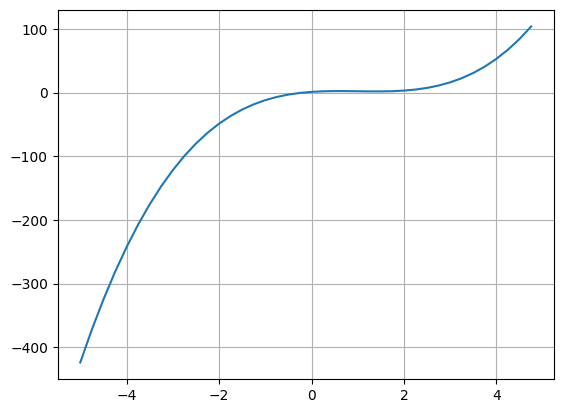

In [30]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.grid()



In [31]:
df = lambda x:  6*x**2 -12*x + 5
print(f'Exact derivative of f w.r.t x at -2:  {df(-2)}')

h = 0.0001
x = -2.0
adf = (f(x+h) - f(x)) / h 
print(f'Approximate derivative of f w.r.t x at -2:  {adf}')

Exact derivative of f w.r.t x at -2:  53
Approximate derivative of f w.r.t x at -2:  52.99820002001354


In [32]:
#We should be careful about h. For very small h, we gut the wrong answer because
# of the finite memory of computer for calculation of floating points. 
h = 0.0000000000000000000001
x = -2.0
adf = (f(x+h) - f(x)) / h 
print(f'Wrong approximate derivative of f w.r.t x at -2 for very small h:  {adf}')

Wrong approximate derivative of f w.r.t x at -2 for very small h:  0.0


In [33]:
# for a function of multiple variables:
d = lambda a,b,c: a*b + c
a = 2 
b = -3 
c = 10

print(d(a,b,c))


4


In [34]:
# derivative of d  w.r.t. a: 
h = 0.001
a2 = a + h 

d1 = d(a,b,c)
d2 = d(a2,b,c)

print(f'd1: {d1}')
print(f'd2: {d2}')
print(f'slope: {(d2 - d1) / h}')


d1: 4
d2: 3.997
slope: -3.0000000000001137


AS we can see, h has been increased for 0.001, but d has decreased for 0.003. so the slope would be -3

In [35]:
h = 0.001
b2 = b + h
c2 = c + h 

d1 = d(a,b,c)
d2_b = d(a,b2,c)
d2_c = d(a,b,c2)

print(f'd1: {d1}')
print(f'd2_b: {d2_b}')
print(f'slope w.r.t. b: {(d2_b - d1) / h}')

print("-------")


print(f'd1: {d1}')
print(f'd2_c: {d2_c}')
print(f'slope w.r.t. c: {(d2_c - d1) / h}')


d1: 4
d2_b: 4.002
slope w.r.t. b: 1.9999999999997797
-------
d1: 4
d2_c: 4.0009999999999994
slope w.r.t. c: 0.9999999999994458


# Value object:

In [36]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        # To define how a Value objects is shown when it is printed
        return f"Value(data = {self.data})"
    
    def __add__(self, other): 
        # To define how two object of Value type be added together
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        # To define how two object of Value type be multiplied together
        return Value(self.data *  other.data)

In [37]:
a = Value(2.0)
b= Value(-3.0)
c = Value(10)
print(a,b)

Value(data = 2.0) Value(data = -3.0)


In [38]:
a * b

Value(data = -6.0)

In [39]:
e = a * b
d = e + c
d

Value(data = 4.0)

In [40]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children) # If a Value object is a result of some mathematical operation on some other Value objects, we save these component Value objects in the _prev attribute. We need this later for the graph visualization
        self._op = _op # Mathematical operation that resulted in a Value object 

    def __repr__(self):
        # To define how a Value objects is shown when it is printed
        return f"Value(data = {self.data})"
    
    def __add__(self, other): 
        # To define how two object of Value type be added together
        return Value(self.data + other.data, _children = (self, other), _op = '+')
    
    def __mul__(self, other):
        # To define how two object of Value type be multiplied together
        return Value(self.data *  other.data, _children = (self, other), _op='*')

In [41]:
a = Value(2.0)
b= Value(-3.0)
c = Value(10)
e = a * b
d = e + c
print(e._prev)
print(d._prev)

{Value(data = 2.0), Value(data = -3.0)}
{Value(data = 10), Value(data = -6.0)}


In [42]:
print(f'Operation that resulted in e: {e._op}')
print(f'Operation that resulted in d: {d._op}')

Operation that resulted in e: *
Operation that resulted in d: +


In [43]:
d._prev

{Value(data = -6.0), Value(data = 10)}

# Visualization of computational graph

In [10]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [83]:
from graphviz import Digraph

def trace(root: Value):
    # build a set of all nodes and edges in a graph starting from the root node all the way down
    
    nodes, edges = set(), set()
    def build(v: Value):
        '''
        A recursive function that start from node (v : Value) and constructs the 2 needed sets
        for graph visualization, i.e. nodes, and edges
        '''
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n)) # The python id() function is used to return a unique identification value of the object stored in the memory. This is quite similar to how unique memory addresses are assigned to each variable and object in the C programming language.
        # For any value in graph create a rectangular ('record') node for it
        dot.node(name = uid, label = "{data %.4f}"%(n.data,), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label= n._op )
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge( str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



In [84]:
a = Value(2.0)
b= Value(-3.0)
c = Value(10)
e = a * b
d = e + c
j = draw_dot(d)

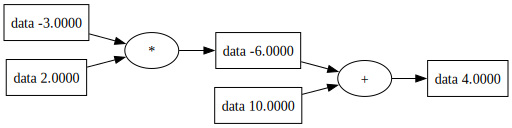

In [87]:
j

### Second version of Value object and draw_dot 

In [105]:
# Adding _label and grad attributes to Value class
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0 # At the beginning, we do not know the effect of this variable on the Loss function. we are going to update this variable iteratively through backpropagation. 
        self._prev = set(_children) # If a Value object is a result of some mathematical operation on some other Value objects, we save these component Value objects in the _prev attribute. We need this later for the graph visualization
        self._op = _op # Mathematical operation that resulted in a Value object 
        self.label = label # For showing which node is which variable later in the graph visualization
        
    def __repr__(self):
        # To define how a Value objects is shown when it is printed
        return f"Value(data = {self.data})"
    
    def __add__(self, other): 
        # To define how two object of Value type be added together
        out = Value(self.data + other.data, _children = (self, other), _op = '+')
        return out

    def __mul__(self, other):
        # To define how two object of Value type be multiplied together
        out =  Value(self.data *  other.data, _children = (self, other), _op='*')
        return out

In [8]:
from graphviz import Digraph

def trace(root: Value):
    # build a set of all nodes and edges in a graph starting from the root node all the way down
    
    nodes, edges = set(), set()
    def build(v: Value):
        '''
        A recursive function that start from node (v : Value) and constructs the 2 needed sets
        for graph visualization, i.e. nodes, and edges
        '''
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n)) # The python id() function is used to return a unique identification value of the object stored in the memory. This is quite similar to how unique memory addresses are assigned to each variable and object in the C programming language.
        # For any value in graph create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}"%(n.label ,n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label= n._op )
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge( str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


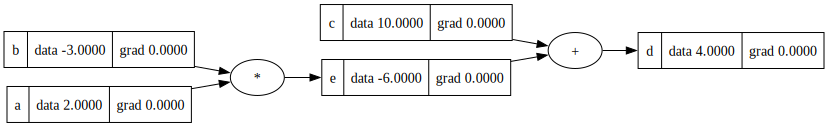

In [107]:
a = Value(2.0, label='a')
b= Value(-3.0, label='b')
c = Value(10, label= 'c')
e = a * b; e.label = 'e' 
d = e + c; d.label = 'd'
draw_dot(d)



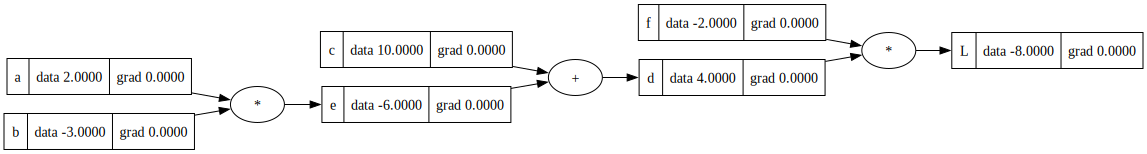

In [155]:
a = Value(2.0, label='a')
b= Value(-3.0, label='b')
c = Value(10, label= 'c')
e = a * b; e.label = 'e' 
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = f * d; L.label = 'L'
draw_dot(L)


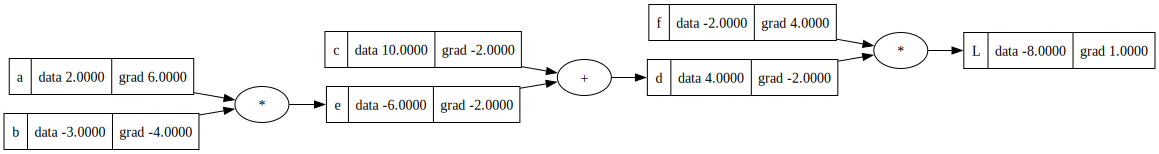

In [156]:
# Now that we have implemented grad attribute for each node, which is basically the derivative of root node (loss function) w.r.t the root , we can assign them to each node
# This is done manually first

#dL/dL
L.grad = 1 

#dL/df = d
f.grad = 4

#dL/dd = f
d.grad = -2

#dL/dc = dL/dd * dd/dc = f * 1
c.grad = f.data * 1

#dL/de = dL/dd * dd/de = f * 1
e.grad = f.data * 1

#dl/da = dL/de * de/da = f * b
a.grad = f.data * b.data

#dL/db = dL/de * de/db = f * a
b.grad = f.data * a.data

draw_dot(L)


In [157]:
# How to minimize loss function: by changing the leaf nodes in the opposite direction of the gradient with small steps
a.data -= 0.01 * a.grad
b.data -= 0.01 * b.grad
c.data -= 0.01 * c.grad
f.data -= 0.01 * f.grad

e = a * b
d = e + c
L2 = d * f

print(L.data)
if L2.data < L.data:
    print('By changing leaf nodes in the opposite direction of gradient (gradient decent), we reached to a less values for loss function. i.e {%.4f} is less than {%.4f}' %(L2.data, L.data))

-8.0
By changing leaf nodes in the opposite direction of gradient (gradient decent), we reached to a less values for loss function. i.e {-8.7263} is less than {-8.0000}


## Implementing a neuron with two inputs and tanh as activation function

In [163]:
# Adding tanh
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0 # At the beginning, we do not know the effect of this variable on the Loss function. we are going to update this variable iteratively through backpropagation. 
        self._prev = set(_children) # If a Value object is a result of some mathematical operation on some other Value objects, we save these component Value objects in the _prev attribute. We need this later for the graph visualization
        self._op = _op # Mathematical operation that resulted in a Value object 
        self.label = label # For showing which node is which variable later in the graph visualization
        
    def __repr__(self):
        # To define how a Value objects is shown when it is printed
        return f"Value(data = {self.data})"
    
    def __add__(self, other): 
        # To define how two object of Value type be added together
        out = Value(self.data + other.data, _children = (self, other), _op = '+')
        return out

    def __mul__(self, other):
        # To define how two object of Value type be multiplied together
        out =  Value(self.data *  other.data, _children = (self, other), _op='*')
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op = 'tanh' )
        return out

In [177]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' 
o = n.tanh()


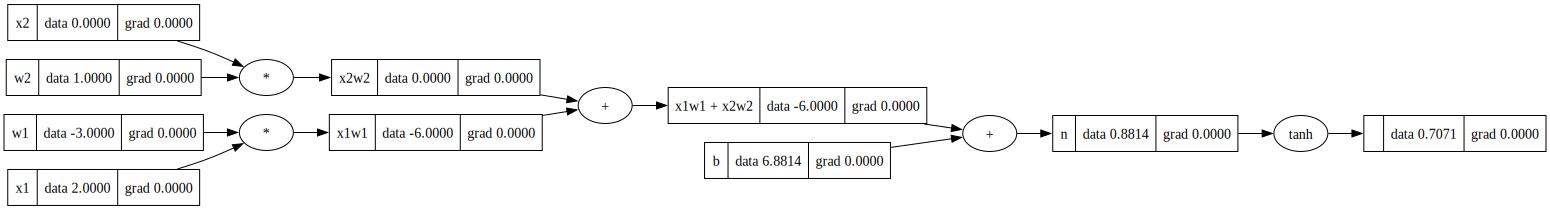

In [178]:
draw_dot(o)

In [179]:
# Manual gradient calculation for each Value node
o.grad = 1

#do/dn = 1 - tanh(n)**2 = 1 - o**2
n.grad = 1 - o.data**2

x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

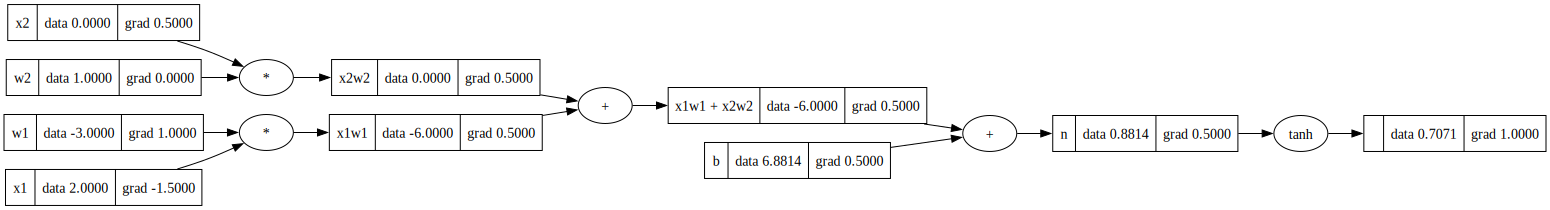

In [180]:
draw_dot(o)

## Automatic implementation of backpropagation

In [5]:
# backwards for automatic gradient
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0 # At the beginning, we do not know the effect of this variable on the Loss function. we are going to update this variable iteratively through backpropagation. 
        self._backward = lambda: None
        self._prev = set(_children) # If a Value object is a result of some mathematical operation on some other Value objects, we save these component Value objects in the _prev attribute. We need this later for the graph visualization
        self._op = _op # Mathematical operation that resulted in a Value object 
        self.label = label # For showing which node is which variable later in the graph visualization
        
    def __repr__(self):
        # To define how a Value objects is shown when it is printed
        return f"Value(data = {self.data})"
    
    def __add__(self, other): 
        # To define how two object of Value type be added together
        out = Value(self.data + other.data, _children = (self, other), _op = '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        # To define how two object of Value type be multiplied together
        out =  Value(self.data *  other.data, _children = (self, other), _op='*')
       
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op = 'tanh' )
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out

In [17]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' 
o = n.tanh()

In [18]:
o.grad = 1.0

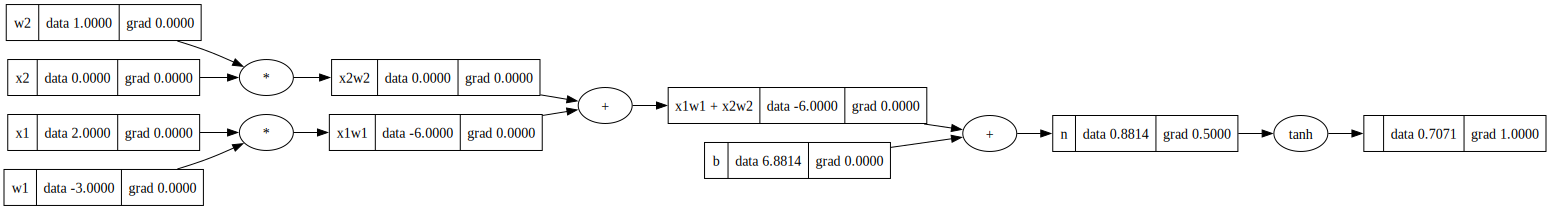

In [19]:

o._backward()
draw_dot(o)

In [20]:
n._backward()
b._backward() # This is leaf node. leaf nodes _backward() return None
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()


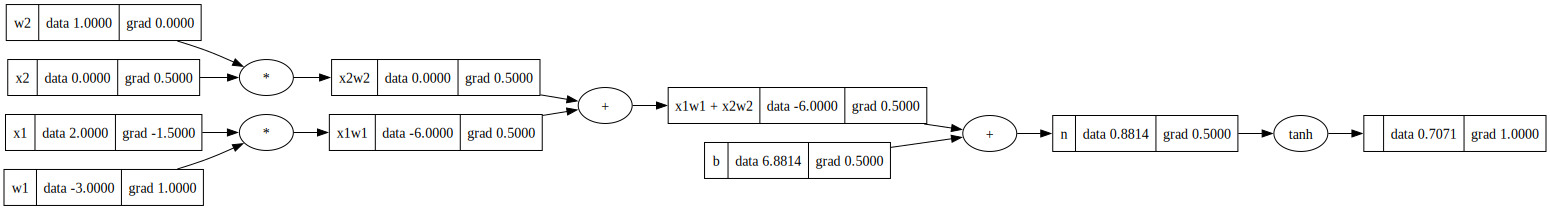

In [21]:
draw_dot(o)

### Make backpropagation automatic


In [31]:
# We want to find topological order of nodes
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
      visited.add(v)
      for child in v._prev:
        build_topo(child)
      topo.append(v)
build_topo(o)
topo

[Value(data = 1.0),
 Value(data = 0.0),
 Value(data = 0.0),
 Value(data = 2.0),
 Value(data = -3.0),
 Value(data = -6.0),
 Value(data = -6.0),
 Value(data = 6.881373587019543),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

In [27]:
# backwards for automatic gradient completely
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0 # At the beginning, we do not know the effect of this variable on the Loss function. we are going to update this variable iteratively through backpropagation. 
        self._backward = lambda: None
        self._prev = set(_children) # If a Value object is a result of some mathematical operation on some other Value objects, we save these component Value objects in the _prev attribute. We need this later for the graph visualization
        self._op = _op # Mathematical operation that resulted in a Value object 
        self.label = label # For showing which node is which variable later in the graph visualization
        
    def __repr__(self):
        # To define how a Value objects is shown when it is printed
        return f"Value(data = {self.data})"
    
    def __add__(self, other): 
        # To define how two object of Value type be added together
        out = Value(self.data + other.data, _children = (self, other), _op = '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        # To define how two object of Value type be multiplied together
        out =  Value(self.data *  other.data, _children = (self, other), _op='*')
       
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op = 'tanh' )
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [28]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' 
o = n.tanh()

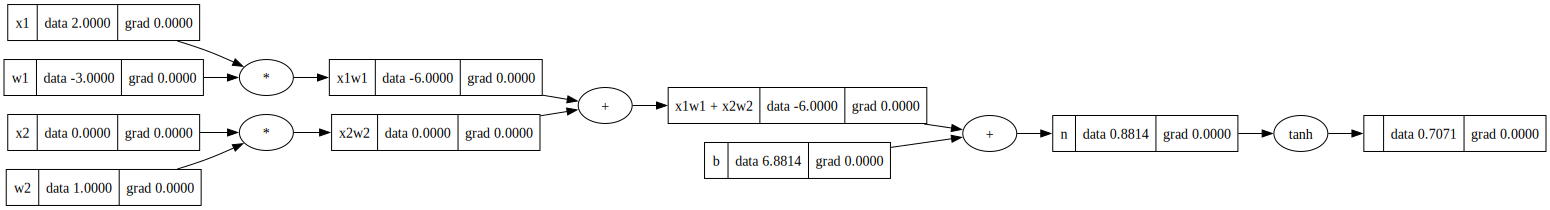

In [29]:
draw_dot(o)

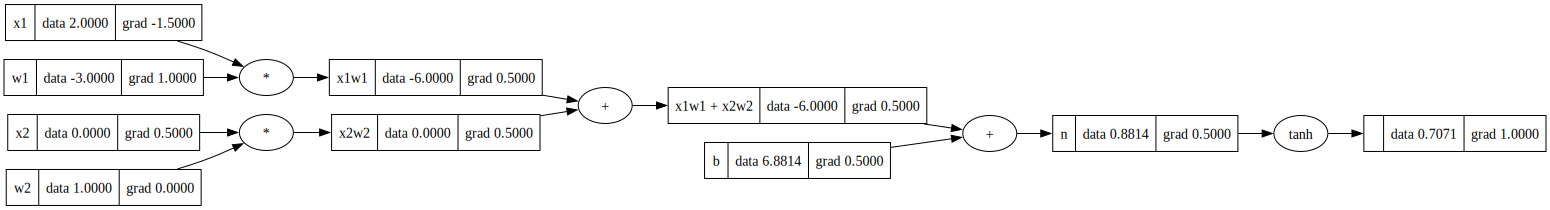

In [30]:
o.backward()
draw_dot(o)